In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


In [3]:
from sklearn.linear_model import LinearRegression

X = data.drop('target', axis=1)
Y = data['target']

model = LinearRegression()
model.fit(X, Y)

print(model.coef_)
print(model.intercept_)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
4.373157038707134


Класс для оптимизации коэффициентов линейной регрессии МНК.
На вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента 
- значение **threshold**'а для критерия останова 
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент **beta**

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадритической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate**
- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. 

- **iteration_loss_dict**: на каждой итерации будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. 

In [9]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        :param samples: матрица объектов
        :param targets: вектор (матрица с 1 столбцом) ответов
        :param learning_rate: параметр learning_rate для корректировки нормы градиента
        :param threshold: величина, меньше которой изменение в loss-функции означает 
        :param copy: копировать сэмплы или делать изменения in-place (см. add_constant_feature)
        """
        if copy:
            self.samples = samples.copy()
        else:
            self.samples = samples
        self.targets = targets
        self.learning_rate = learning_rate
        self.threshold = threshold
        
        self.beta = np.ones(self.samples.shape[1])
        self.iteration_num = 0
        self.iteration_loss_dict = {}
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        """
        self.samples['constant'] = 1    
        self.beta = np.append(self.beta, 1)
        
    def calculate_mse_loss(self) -> float:
        """
        Метод для создания константной фичи в матрице объектов samples
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        loss = np.dot(self.samples, self.beta)  - self.targets.values
        
        return np.mean(loss**2)

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        shift = np.dot(self.samples, self.beta)  - self.targets.values
        derivatives = 2 * np.dot(shift, self.samples) / self.samples.shape[0]
        
        return derivatives
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        self.beta = self.beta - self.learning_rate * self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        """
        previous_mse = self.calculate_mse_loss()
        
        self.iteration()
        
        next_mse = self.calculate_mse_loss()
        
        self.iteration_loss_dict[0] = previous_mse
        self.iteration_loss_dict[1] = next_mse
        
        self.iteration_num = 1
        
        while abs(next_mse - previous_mse) >= self.threshold:
            
            previous_mse = next_mse
            
            self.iteration()
            
            next_mse = self.calculate_mse_loss()
            
            self.iteration_loss_dict[self.iteration_num+1] = next_mse
            
            self.iteration_num += 1

In [10]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [11]:
print('Веса модели при переменных d0, d1, ..., d10, d0 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10, d0 равны соответственно: 

[0.88733305 1.90100713 2.88063607 3.87662612 4.89623507 5.89126182
 6.89254811 7.90311947 8.87580109 9.86109585 4.94854733]


In [14]:
GD_new = GradientDescentMse(samples=X, targets=Y, learning_rate=1)
GD_new.add_constant_feature()
GD_new.learn()

In [17]:
#взрывающиеся градиенты
print('Веса модели при переменных d0, d1, ..., d10, d0 равны соответственно: \n\n' + str(GD_new.beta))

Веса модели при переменных d0, d1, ..., d10, d0 равны соответственно: 

[9.40188501e+152 9.18141651e+152 8.60666268e+152 8.65906169e+152
 8.84957221e+152 9.26558544e+152 9.00779348e+152 9.33707984e+152
 8.88112792e+152 8.93870956e+152 1.77388075e+153]


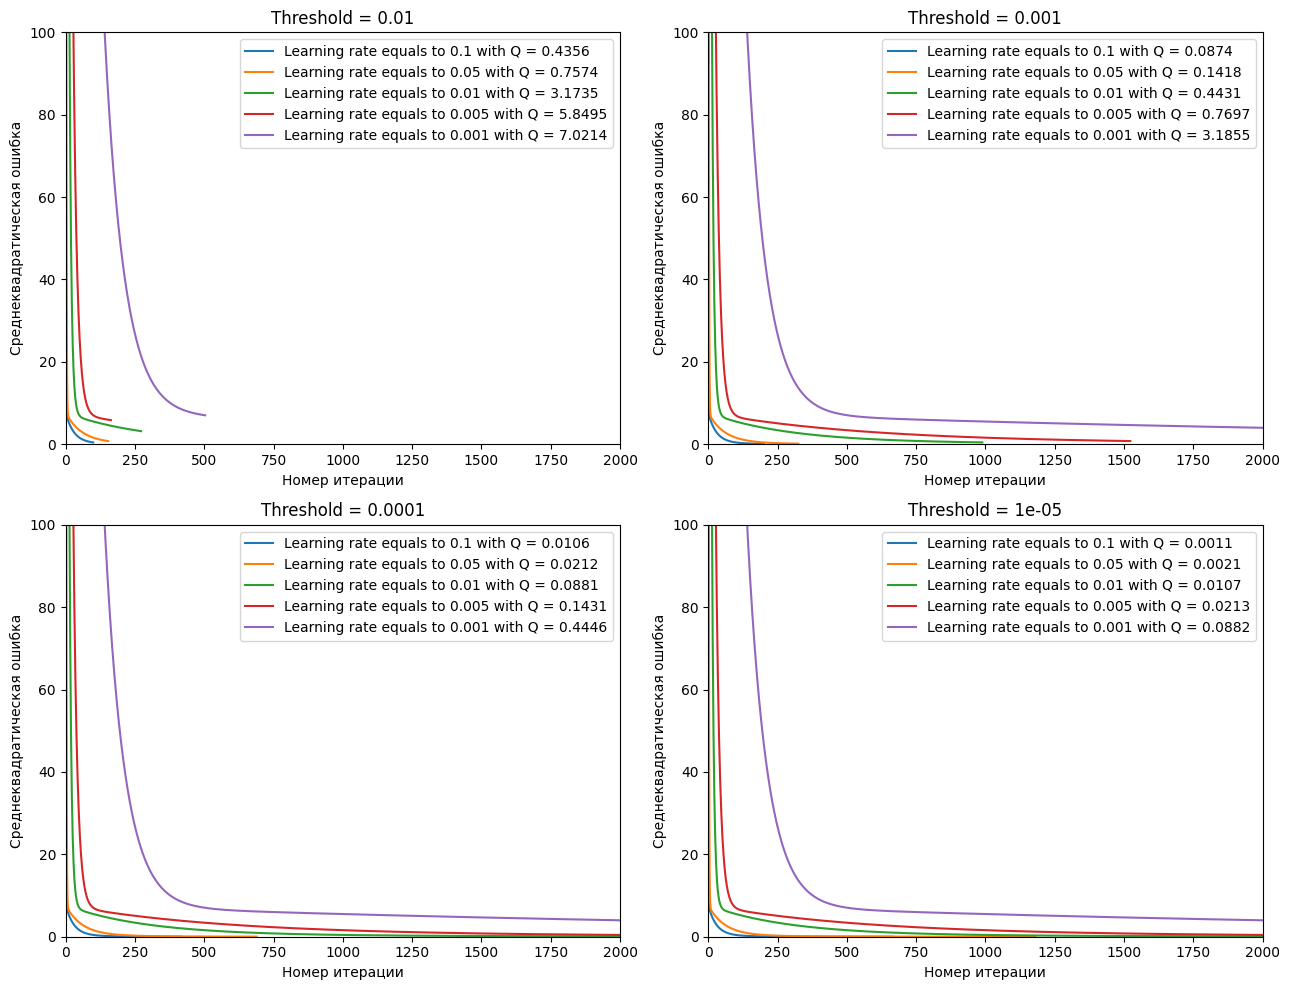

In [16]:
#визуализация learning paths c разными threshold и learning rate
fig = plt.figure()

fig.set_size_inches(13, 10)

rates = [0.1, 0.05, 0.01, 0.005, 0.001]
thresholds = [0.01, 0.001, 0.0001, 0.00001]

for i in range(len(thresholds)):
    thresh = thresholds[i]
    
    ax_ = fig.add_subplot(2, 2, i+1)
    
    Q_values = []
    
    for lr in rates:
        GD = GradientDescentMse(samples=X, targets=Y, 
                                learning_rate=lr, threshold=thresh)
        GD.add_constant_feature()
        GD.learn()

        learning_path = GD.iteration_loss_dict

        plt.plot(learning_path.keys(), learning_path.values())
        plt.title(f'Threshold = {thresh}')
        plt.ylim(0, 100)
        plt.xlim(0, 2000)
        
        Q_values.append(str(round(list(learning_path.values())[-1], ndigits=4)))
    
    plt.ylabel('Среднеквадратическая ошибка')
    plt.xlabel('Номер итерации')
    plt.legend([f'Learning rate equals to {rates[i]}' + ' with Q = ' + Q_values[i] for i in range(len(rates))])

fig.tight_layout() 

plt.show()